In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [2]:
np.random.seed(42)
set_config(display='diagram')

In [3]:
# additional setup of the tools
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="whitegrid")

In [4]:
trainDf = pd.read_csv("data/train.csv")
testDf = pd.read_csv("data/test.csv")

In [5]:
# Remove outliers
trainDf.drop(
    trainDf[(trainDf["GrLivArea"] > 4000) & (trainDf["SalePrice"] < 700000)].index
);

In [6]:
baselineFeatures = [
    '1stFlrSF',
    '2ndFlrSF',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    #'BsmtFinType1',
    #'BsmtFinType2',
    'BsmtUnfSF',
    'OverallQual',
    'GarageCars', 
    'OverallCond', 
    'Neighborhood', 
    'MSSubClass', 
    'LotShape',
    'LandSlope',
    'BsmtCond',
    'BsmtQual',
]

X = trainDf[baselineFeatures]
Y = trainDf['SalePrice']

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.3, random_state=42)

In [8]:
subclassCategories = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]
#basementFinishCategories = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

In [9]:
# Build feature transformer

basementCondTransformer = Pipeline([
    ('basement_condition_impute', SimpleImputer(strategy="constant", fill_value='None')),
    ('basement_condition_onehot', OneHotEncoder()),
])

#basementFinishTransformer = Pipeline([
#    ('basement_finish_impute', SimpleImputer(strategy="constant", fill_value='None')),
#    ('basement_finish_onehot', OrdinalEncoder(categories=[basementFinishCategories, basementFinishCategories])),
#])

featureTransformer = ColumnTransformer([
        ('garage_cars_impute', SimpleImputer(strategy="constant", fill_value=0), ['GarageCars']),
        ('basement_area_impute', SimpleImputer(strategy="constant", fill_value=0), ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']),
        ('neighborhood_onehot', OneHotEncoder(), ['Neighborhood']),
        ('subclass_onehot', OneHotEncoder(categories=[subclassCategories]), ['MSSubClass']),
        ('lot_shape_onehot', OneHotEncoder(), ['LotShape']),
        ('land_slope_onehot', OneHotEncoder(), ['LandSlope']),
        ('basement_condition_transformer', basementCondTransformer, ['BsmtCond', 'BsmtQual']),
        #('basement_finish_transformer', basementFinishTransformer, ['BsmtFinType1', 'BsmtFinType2']),
    ],
    remainder='passthrough'
)

In [10]:
# Initialize Regression Model

baselineModel = LinearRegression()

In [11]:
regressionPipeline = Pipeline([
    ("preprocessing", featureTransformer),
    ("regression", baselineModel)
])

regressionPipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('garage_cars_impute',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['GarageCars']),
                                                 ('basement_area_impute',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF']),
                                                 ('neighborhood_onehot',
                                                  OneHotEncoder(),
                                                  ['Neighborhood']),
                                                 ('sub...
                                                  ['MSSubClass']),
                                                 ('lot_shape_onehot',
                                                  OneHotEncoder(),
                                                  ['LotShape']),
                                                 ('land_slope_onehot',
                                                  OneHotEncoder(),
                                                  ['LandSlope']),
                                                 ('basement_condition_transformer',
                                                  Pipeline(steps=[('basement_condition_impute',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('basement_condition_onehot',
                                                                   OneHotEncoder())]),
                                                  ['BsmtCond', 'BsmtQual'])])),
                ('regression', LinearRegression())])

In [12]:
regressionPipeline.fit(X_train, y_train)

y_train_predicted = regressionPipeline.predict(X_train)
y_validation_predicted = regressionPipeline.predict(X_validation)

In [13]:
## Metrics from Test Data
print('[Train] Mean Squared Error: %.2f' % mean_squared_error(y_train, y_train_predicted))
# The coefficient of determination: 1 is perfect prediction
print('[Train] Coefficient of Determination: %.2f' % r2_score(y_train, y_train_predicted))

[Train] Mean Squared Error: 946472908.12
[Train] Coefficient of Determination: 0.84


In [14]:
## Metrics from Test Data
print('[Test] Mean Squared Error: %.2f' % mean_squared_error(y_validation, y_validation_predicted))
# The coefficient of determination: 1 is perfect prediction
print('[Test] Coefficient of Determination: %.2f' % r2_score(y_validation, y_validation_predicted))

[Test] Mean Squared Error: 941035100.42
[Test] Coefficient of Determination: 0.87


In [15]:
def plot_regression_results(ax, y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
    ax.set_title(title)

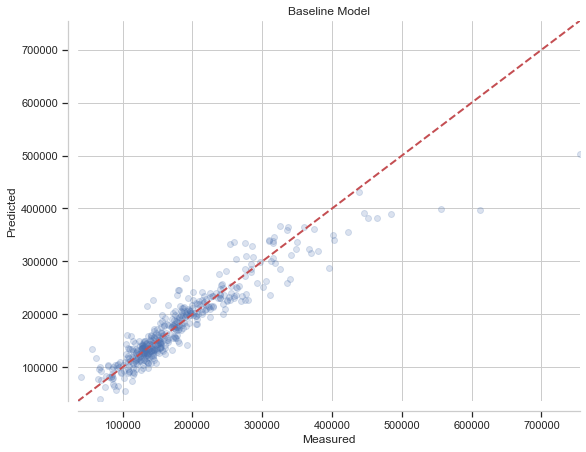

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

plot_regression_results(
    ax, 
    y_true=y_validation, 
    y_pred=y_validation_predicted, 
    title="Baseline Model"
)

In [17]:
x_test = testDf[baselineFeatures]
y_test_predicted = regressionPipeline.predict(x_test)

submissionDf = pd.DataFrame({
    'Id': testDf['Id'],
    'SalePrice': y_test_predicted,
})

submissionDf.to_csv('./data/submission.csv', index=False)